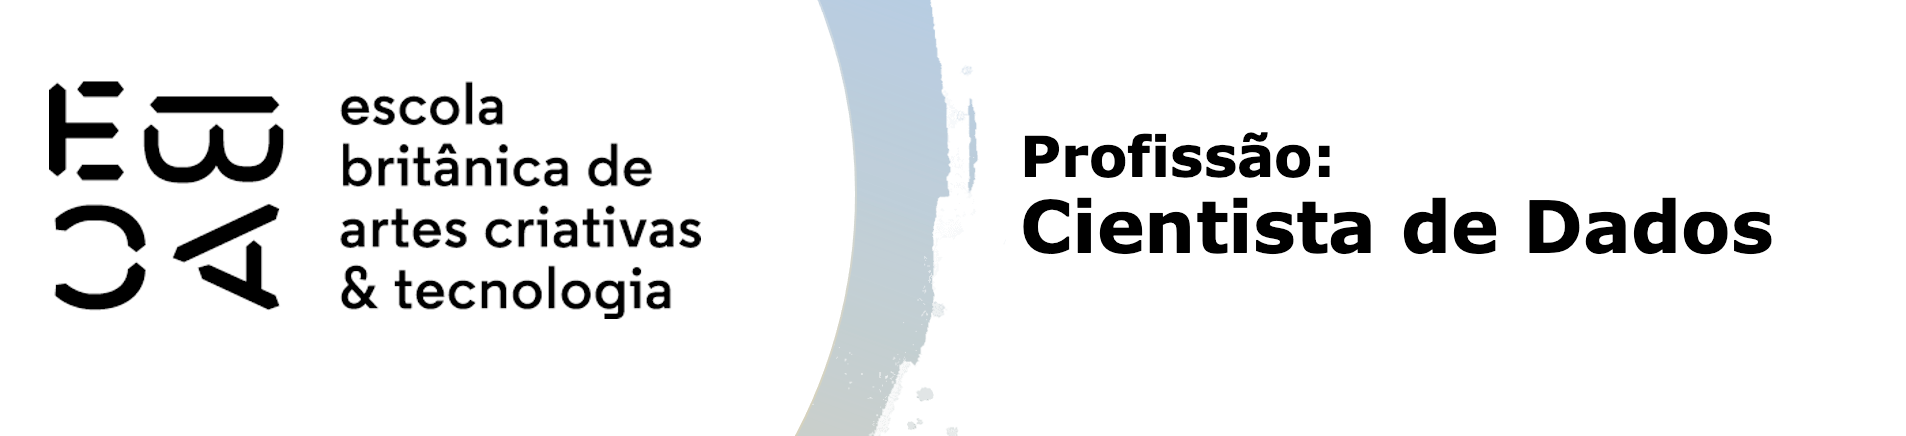

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

In [5]:
df['dia_semana'] = df['Data Emissão'].dt.dayofweek

In [7]:
df['fim_semana'] = df['dia_semana'].isin([5, 6]).astype(int)

In [9]:
df['dia_mes'] = df['Data Emissão'].dt.day

In [11]:
df['mes'] = df['Data Emissão'].dt.month

In [13]:
df['trimestre'] = df['Data Emissão'].dt.quarter

In [15]:
df['ano'] = df['Data Emissão'].dt.year

In [17]:
df['Valor NF'].describe()

count    187646.000000
mean        132.505844
std        1617.620850
min           0.000000
25%          16.900000
50%          38.880000
75%         101.480000
max      562500.000000
Name: Valor NF, dtype: float64

In [19]:
def criar_quantils(df, coluna, n_bins, nome):
    df[nome] = pd.qcut(
        df[coluna],
        q=n_bins,
        duplicates='drop'
    )

In [21]:
criar_quantils(df, 'Valor NF', 5, 'valor_nf_q5')

In [23]:
criar_quantils(df, 'Valor NF', 10, 'valor_nf_q10')

In [25]:
criar_quantils(df, 'Valor NF', 20, 'valor_nf_q20')

In [27]:
criar_quantils(df, 'Valor NF', 50, 'valor_nf_q50')

In [29]:
df[['Valor NF', 'valor_nf_q5', 'valor_nf_q10']].head()

,Valor NF,valor_nf_q5,valor_nf_q10
0,24.68,"(13.36, 28.61]","(20.29, 28.61]"
1,50.00,"(28.61, 55.0]","(38.88, 55.0]"
2,27.00,"(13.36, 28.61]","(20.29, 28.61]"
3,111.50,"(55.0, 131.36]","(81.8, 131.36]"
4,125.00,"(55.0, 131.36]","(81.8, 131.36]"


----------

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [32]:
metadata = pd.DataFrame({
    'variavel': [
        'categoria',
        'dia_semana',
        'fim_semana',
        'dia_mes',
        'mes',
        'trimestre',
        'ano',
        'valor_nf_q5',
        'valor_nf_q10',
        'valor_nf_q20',
        'valor_nf_q50'
    ],
    'tipo': [
        'categorica',
        'categorica',
        'categorica',
        'binaria',
        'categorica',
        'categorica',
        'categorica',
        'categorica',
        'categorica',
        'categorica',
        'categorica'
    ]
})

metadata

,variavel,tipo
0,categoria,categorica
1,dia_semana,categorica
2,fim_semana,categorica
3,dia_mes,binaria
4,mes,categorica
5,trimestre,categorica
6,ano,categorica
7,valor_nf_q5,categorica
8,valor_nf_q10,categorica
9,valor_nf_q20,categorica


In [34]:
import numpy as np

def calcula_iv(df, var, target, eps=0.5):
    tab = (
        df
        .groupby(var)[target]
        .agg(total='count', eventos='sum')
    )
    
    tab['nao_eventos'] = tab['total'] - tab['eventos']
    
    total_eventos = tab['eventos'].sum()
    total_nao_eventos = tab['nao_eventos'].sum()
    
    tab['perc_eventos'] = (tab['eventos'] + eps) / (total_eventos + eps * len(tab))
    tab['perc_nao_eventos'] = (tab['nao_eventos'] + eps) / (total_nao_eventos + eps * len(tab))
    
    tab['woe'] = np.log(tab['perc_eventos'] / tab['perc_nao_eventos'])
    tab['iv_parcial'] = (tab['perc_eventos'] - tab['perc_nao_eventos']) * tab['woe']
    
    iv = tab['iv_parcial'].sum()
    
    return iv

In [36]:
resultados_iv = []

for _, row in metadata.iterrows():
    var = row['variavel']
    
    iv = calcula_iv(
        df=df,
        var=var,
        target='flag_credito'
    )
    
    resultados_iv.append({
        'variavel': var,
        'IV': iv
    })

iv_df = pd.DataFrame(resultados_iv).sort_values('IV', ascending=False)

iv_df

C:\Users\renna\AppData\Local\Temp\ipykernel_16588\1120514747.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(var)[target]
C:\Users\renna\AppData\Local\Temp\ipykernel_16588\1120514747.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(var)[target]
C:\Users\renna\AppData\Local\Temp\ipykernel_16588\1120514747.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(var)[target]
C:\Users\renna\AppD

,variavel,IV
0,categoria,0.408198
10,valor_nf_q50,0.152217
9,valor_nf_q20,0.124495
8,valor_nf_q10,0.106638
7,valor_nf_q5,0.056692
3,dia_mes,0.043706
6,ano,0.041759
4,mes,0.027830
5,trimestre,0.011507
1,dia_semana,0.006883


----

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

## O cálculo automatizado do Information Value (IV) evidenciou que a variável categoria do estabelecimento apresenta forte poder preditivo (IV = 0,41) na geração de créditos da Nota Fiscal Paulista. As variáveis derivadas do valor da nota apresentam poder preditivo médio, com ganho incremental à medida que aumenta a granularidade da discretização. Variáveis temporais apresentam baixo ou irrelevante poder discriminatório, sugerindo que efeitos de calendário exercem influência limitada no retorno de créditos.

| Variável      | IV        | Interpretação |
| ------------- | --------- | ------------- |
| **categoria** | **0.408** | **Forte**  |
| valor_nf_q50  | 0.152     | Médio         |
| valor_nf_q20  | 0.124     | Médio         |
| valor_nf_q10  | 0.107     | Médio         |
| valor_nf_q5   | 0.057     | Fraco         |
| dia_mes       | 0.044     | Fraco         |
| ano           | 0.042     | Fraco         |
| mes           | 0.028     | Fraco         |
| trimestre     | 0.012     | Irrelevante   |
| dia_semana    | 0.007     | Irrelevante   |
| fim_semana    | 0.004     | Irrelevante   |


### Observa-se que o Information Value aumenta à medida que cresce o número de categorias utilizadas na discretização da variável contínua, refletindo maior capacidade de captura de relações não lineares. No entanto, esse aumento está associado a maior granularidade e potencial instabilidade, sendo necessário equilibrar poder discriminatório e robustez. Dessa forma, optou-se por uma discretização intermediária, que apresenta bom desempenho sem comprometer a estabilidade do modelo.

------

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [45]:
# Garantir datetime
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# Criar trimestre (timestamp do início do trimestre)
df['trimestre_dt'] = df['Data Emissão'].dt.to_period('Q').dt.to_timestamp()

# Evento
df['retorno_pos'] = (df['Retorno'] > 0).astype(int)

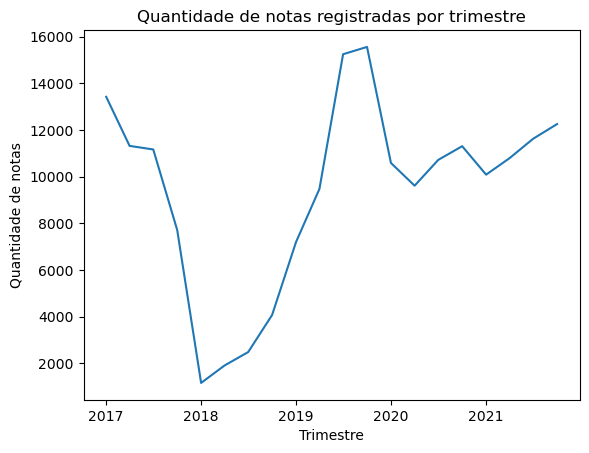

In [47]:
# Quantidade de notas registradas por período (trimestre)
notas_trimestre = (
    df
    .groupby('trimestre_dt')
    .size()
    .rename('qtd_notas')
)

plt.figure()
plt.plot(notas_trimestre.index, notas_trimestre.values)
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de notas')
plt.title('Quantidade de notas registradas por trimestre')
plt.show()

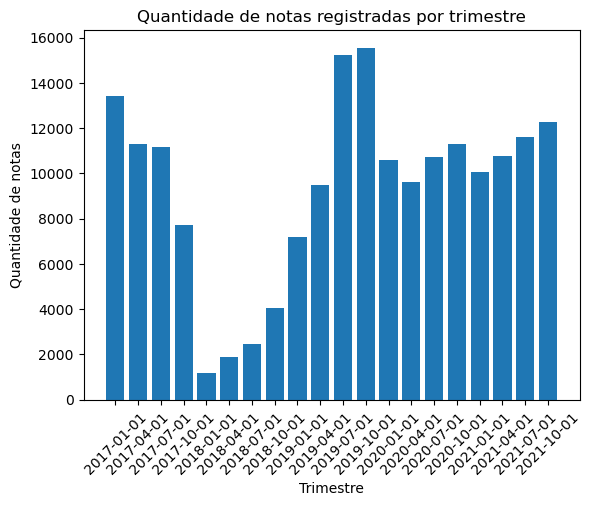

In [55]:
plt.figure()
plt.bar(
    notas_trimestre.index.astype(str),
    notas_trimestre.values
)
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de notas')
plt.title('Quantidade de notas registradas por trimestre')
plt.xticks(rotation=45)
plt.show()

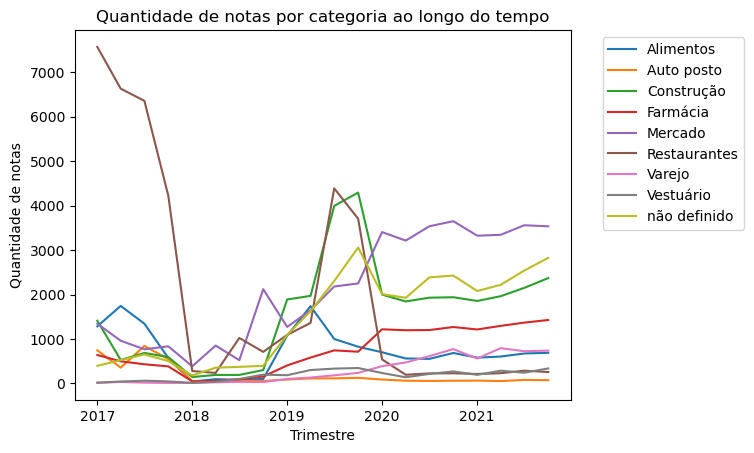

In [49]:
# Quantidade de notas por categoria e por período
notas_cat_trimestre = (
    df
    .groupby(['trimestre_dt', 'categoria'])
    .size()
    .reset_index(name='qtd_notas')
)

# Pivot para facilitar o plot
pivot_qtd = notas_cat_trimestre.pivot(
    index='trimestre_dt',
    columns='categoria',
    values='qtd_notas'
).fillna(0)

plt.figure()
for col in pivot_qtd.columns:
    plt.plot(pivot_qtd.index, pivot_qtd[col], label=col)

plt.xlabel('Trimestre')
plt.ylabel('Quantidade de notas')
plt.title('Quantidade de notas por categoria ao longo do tempo')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

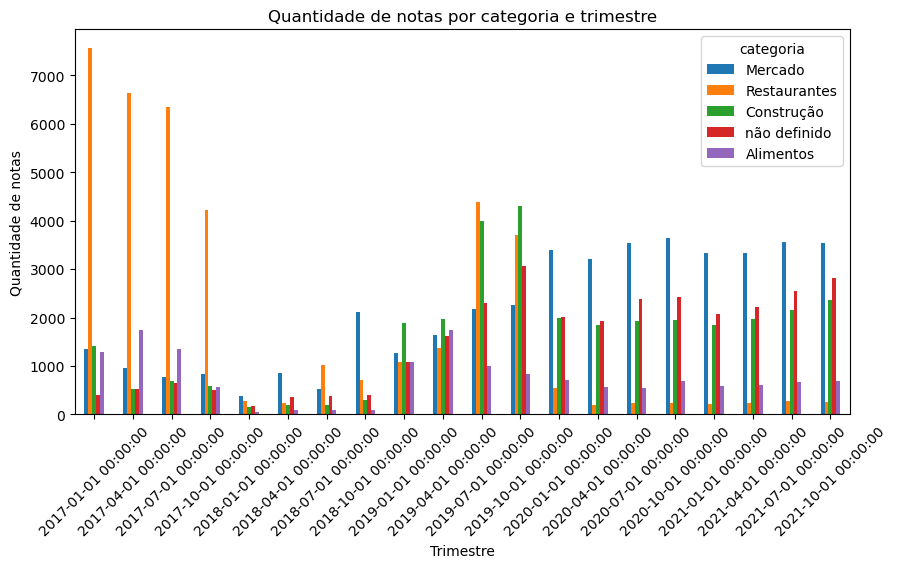

In [57]:
# Selecionar categorias mais frequentes
top_categorias = (
    df['categoria']
    .value_counts()
    .nlargest(5)
    .index
)

dados_plot = pivot_qtd[top_categorias]

dados_plot.plot(
    kind='bar',
    figsize=(10, 5)
)

plt.xlabel('Trimestre')
plt.ylabel('Quantidade de notas')
plt.title('Quantidade de notas por categoria e trimestre')
plt.xticks(rotation=45)
plt.show()

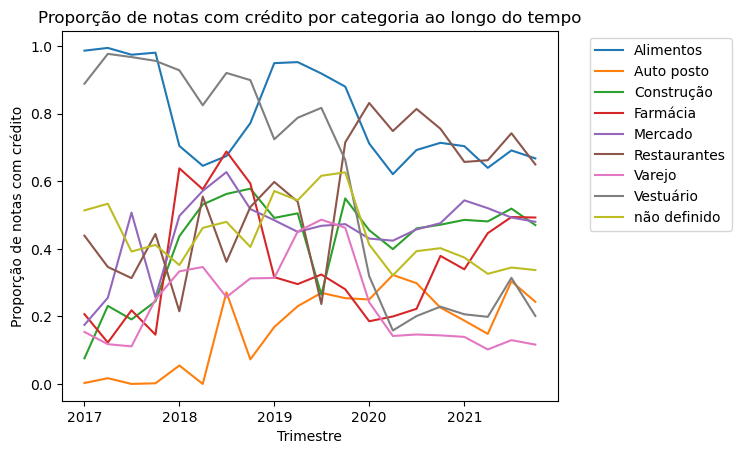

In [51]:
# Proporção de notas com crédito por categoria e por período
prop_credito_cat_trim = (
    df
    .groupby(['trimestre_dt', 'categoria'])
    .agg(
        total=('retorno_pos', 'count'),
        com_credito=('retorno_pos', 'sum')
    )
    .reset_index()
)

prop_credito_cat_trim['proporcao'] = (
    prop_credito_cat_trim['com_credito'] /
    prop_credito_cat_trim['total']
)

# Pivot
pivot_prop = prop_credito_cat_trim.pivot(
    index='trimestre_dt',
    columns='categoria',
    values='proporcao'
)

plt.figure()
for col in pivot_prop.columns:
    plt.plot(pivot_prop.index, pivot_prop[col], label=col)

plt.xlabel('Trimestre')
plt.ylabel('Proporção de notas com crédito')
plt.title('Proporção de notas com crédito por categoria ao longo do tempo')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

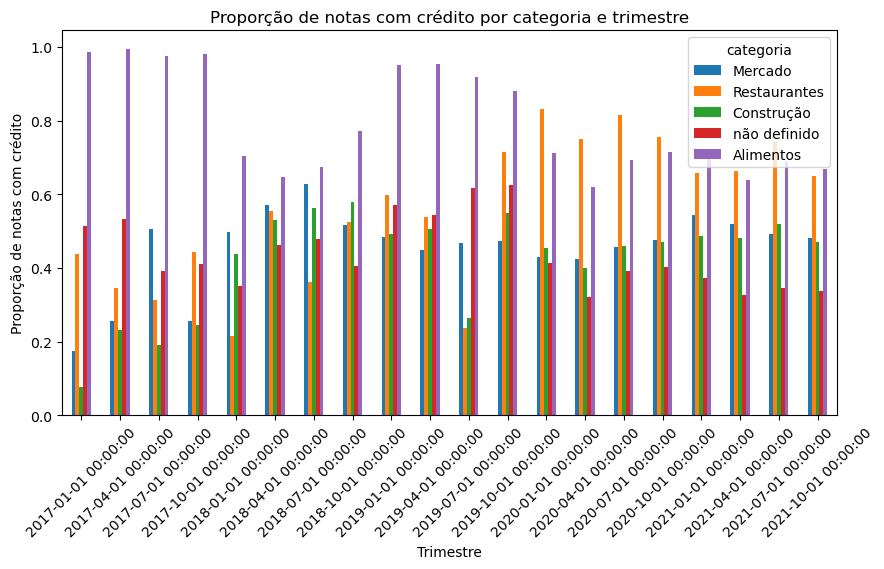

In [59]:
pivot_prop[top_categorias].plot(
    kind='bar',
    figsize=(10, 5)
)

plt.xlabel('Trimestre')
plt.ylabel('Proporção de notas com crédito')
plt.title('Proporção de notas com crédito por categoria e trimestre')
plt.xticks(rotation=45)
plt.show()

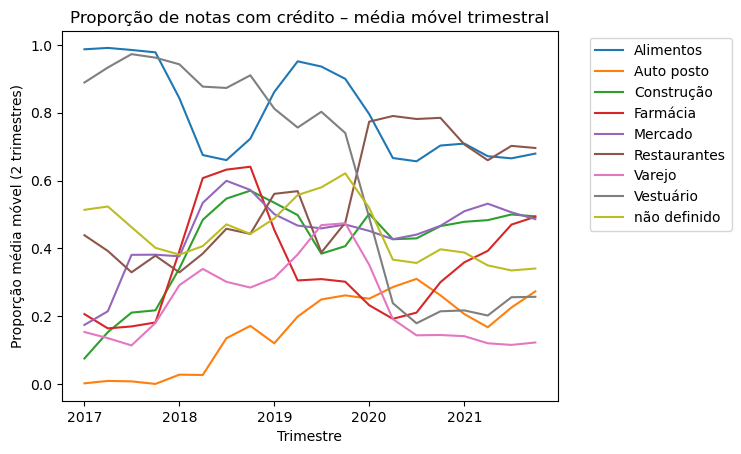

In [53]:
# Média móvel trimestral
pivot_prop_mm = pivot_prop.rolling(2, min_periods=1).mean()

plt.figure()
for col in pivot_prop_mm.columns:
    plt.plot(pivot_prop_mm.index, pivot_prop_mm[col], label=col)

plt.xlabel('Trimestre')
plt.ylabel('Proporção média móvel (2 trimestres)')
plt.title('Proporção de notas com crédito – média móvel trimestral')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### A análise descritiva temporal evidencia forte heterogeneidade tanto no volume de notas quanto na composição das categorias ao longo do tempo. Observa-se ainda que a proporção de notas com crédito positivo varia significativamente entre categorias e entre trimestres, indicando que o efeito da categoria sobre a geração de créditos não é constante no tempo. Esses resultados reforçam a importância de abordagens que considerem instabilidade temporal e justificam o poder preditivo observado da variável categoria.

----

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [64]:
df['trimestre'] = df['Data Emissão'].dt.to_period('Q').astype(str)

In [66]:
def calcula_woe_iv(df, var, target):
    resumo = (
        df
        .groupby(var)[target]
        .agg(['count', 'sum'])
        .rename(columns={'count': 'total', 'sum': 'eventos'})
    )
    
    resumo['nao_eventos'] = resumo['total'] - resumo['eventos']
    
    total_eventos = resumo['eventos'].sum()
    total_nao_eventos = resumo['nao_eventos'].sum()
    
    resumo['perc_eventos'] = resumo['eventos'] / total_eventos
    resumo['perc_nao_eventos'] = resumo['nao_eventos'] / total_nao_eventos
    
    # Evitar log(0)
    resumo['WOE'] = np.log(
        (resumo['perc_eventos'] + 1e-6) / (resumo['perc_nao_eventos'] + 1e-6)
    )
    
    resumo['IV_parcial'] = (
        (resumo['perc_eventos'] - resumo['perc_nao_eventos']) * resumo['WOE']
    )
    
    return resumo.reset_index()

In [68]:
lista_woe = []

for trimestre in df['trimestre'].unique():
    df_temp = df[df['trimestre'] == trimestre]
    
    woe_temp = calcula_woe_iv(
        df_temp,
        var='categoria',
        target='flag_credito'
    )
    
    woe_temp['trimestre'] = trimestre
    lista_woe.append(woe_temp)

woe_time_df = pd.concat(lista_woe, ignore_index=True)

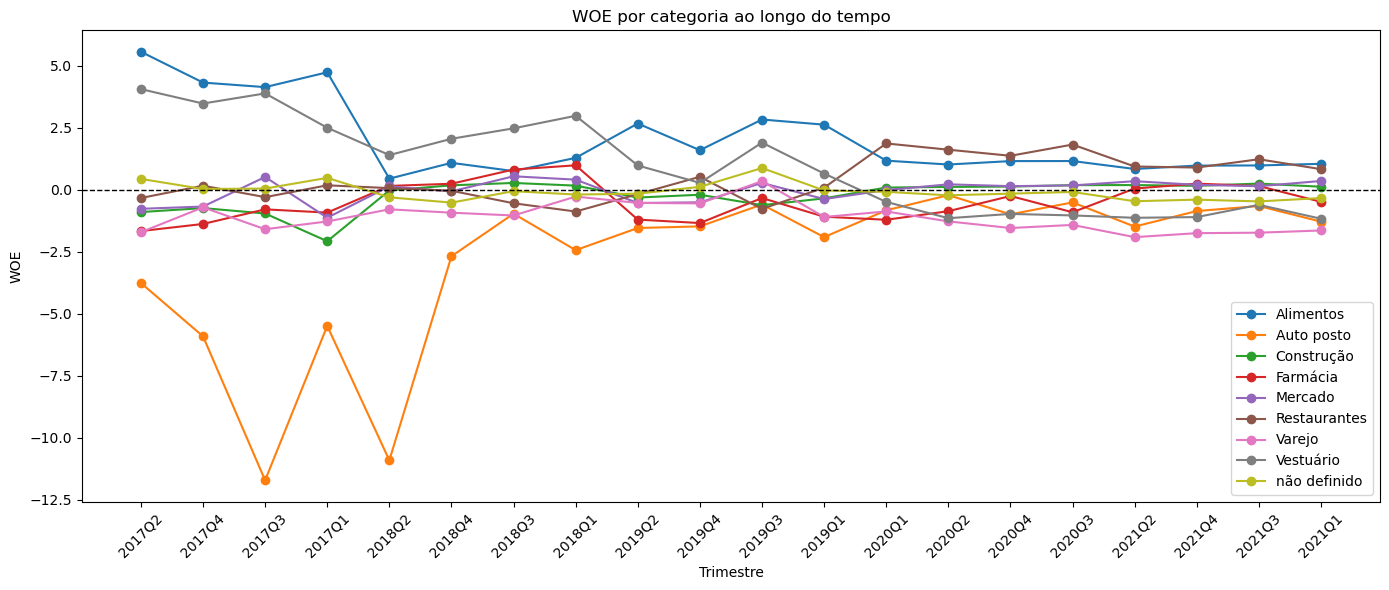

In [70]:
# WOE por categoria ao longo do tempo
plt.figure(figsize=(14, 6))

for cat in woe_time_df['categoria'].unique():
    dados_cat = woe_time_df[woe_time_df['categoria'] == cat]
    plt.plot(dados_cat['trimestre'], dados_cat['WOE'], marker='o', label=cat)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.ylabel('WOE')
plt.xlabel('Trimestre')
plt.title('WOE por categoria ao longo do tempo')
plt.legend()
plt.tight_layout()
plt.show()


In [72]:
# IV da variável categoria ao longo do tempo
iv_time_df = (
    woe_time_df
    .groupby('trimestre', as_index=False)['IV_parcial']
    .sum()
    .rename(columns={'IV_parcial': 'IV'})
)

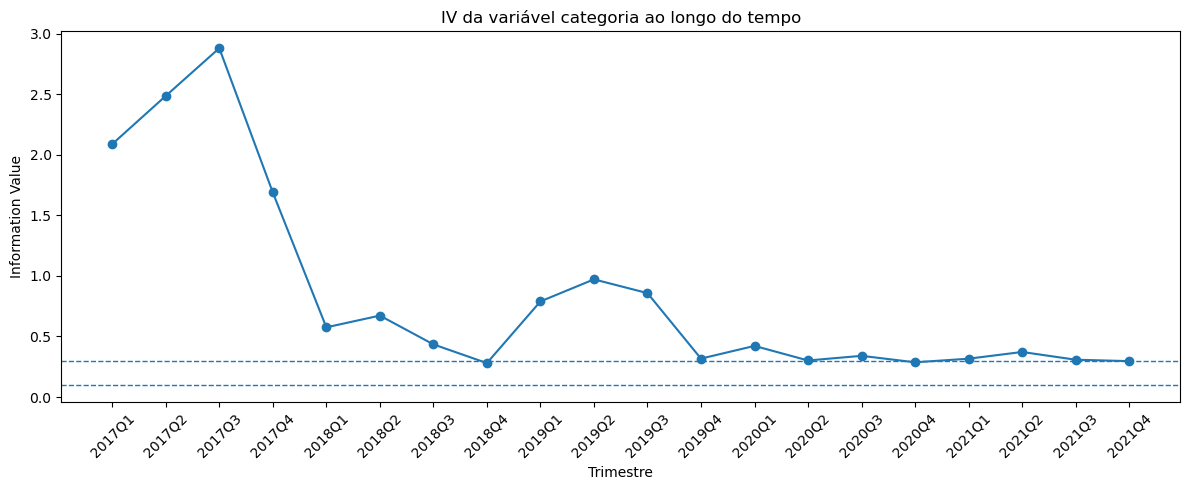

In [74]:
plt.figure(figsize=(12, 5))
plt.plot(iv_time_df['trimestre'], iv_time_df['IV'], marker='o')

plt.axhline(0.1, linestyle='--', linewidth=1)
plt.axhline(0.3, linestyle='--', linewidth=1)

plt.xticks(rotation=45)
plt.ylabel('Information Value')
plt.xlabel('Trimestre')
plt.title('IV da variável categoria ao longo do tempo')
plt.tight_layout()
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

| Categoria          | Sinal              | Estabilidade |
| ------------------ | ------------------ | ------------ |
| Alimentos          | Positivo           | Alta         |
| Mercado            | Levemente positivo | Alta         |
| Restaurantes       | Positivo           | Média        |
| Construção         | Próximo de zero    | Média        |
| Farmácia           | Próximo de zero    | Média        |
| Auto posto         | Negativo           | Alta         |
| Varejo / Vestuário | Negativo           | Alta         |


### As categorias Alimentos, Mercado e Restaurantes apresentam maior proporção de notas com retorno positivo, sendo Alimentos a mais consistente ao longo do período analisado. Em contrapartida, categorias como Auto posto, Varejo e Vestuário apresentam menor propensão à geração de créditos. Observa-se, entretanto, que a magnitude dessas diferenças não é totalmente estável no tempo, com variações relevantes no WOE e no IV, especialmente nos períodos iniciais da base, indicando dependência temporal e possíveis mudanças de regra ou composição da base ao longo dos anos. 

----